In [2]:
import tensorflow as tf
from tensorflow.keras.layers import Input, Conv2D, MaxPooling2D, Flatten, Dense, BatchNormalization, Activation, Add
from tensorflow.keras.models import Model
import os
import zipfile
import matplotlib.pyplot as plt
import numpy as np
from sklearn.metrics import confusion_matrix
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense
from keras.optimizers import Adam


input_shape = (48, 48, 1)
dataset_path = "/kaggle/input/facialemotionrecognitionusingdeeplearning"
batch_size = 64
num_train_samples = 28729
num_test_samples = 7178

train_data_generator = ImageDataGenerator(rescale=1./255)
test_data_generator = ImageDataGenerator(rescale=1./255)

train_data = train_data_generator.flow_from_directory(
    os.path.join(dataset_path, 'TrainingSet'),
    color_mode='grayscale',
    target_size=input_shape[:2],
    batch_size=batch_size,
    class_mode='categorical',
    shuffle=True
)

test_data = test_data_generator.flow_from_directory(
    os.path.join(dataset_path, 'TestSet/test'),
    color_mode='grayscale',
    target_size=input_shape[:2],
    batch_size=batch_size,
    class_mode='categorical',
    shuffle=False
)



from keras.models import Sequential
import numpy as np
import tensorflow as tf
np.random.seed(42)
tf.random.set_seed(42)


/opt/conda/lib/python3.10/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.24.3
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


Found 28729 images belonging to 7 classes.
Found 7178 images belonging to 7 classes.


In [3]:
def residual_block(x, filters, kernel_size=(3, 3), stride=(1, 1), padding='same'):
    shortcut = x
    
    # First convolution layer
    x = Conv2D(filters, kernel_size, strides=stride, padding=padding)(x)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)
    
    # Second convolution layer
    x = Conv2D(filters, kernel_size, padding=padding)(x)
    x = BatchNormalization()(x)
    
    # Add the shortcut to the output
    x = Add()([x, shortcut])
    x = Activation('relu')(x)
    
    return x


def build_vgg_with_resnet(input_shape, num_classes):
    input_layer = Input(shape=input_shape)
    
    # VGG-like convolutional layers with residual blocks
    x = Conv2D(64, (3, 3), padding='same', activation='relu')(input_layer)
    x = residual_block(x, 64)
    x = MaxPooling2D(pool_size=(2, 2))(x)
    
    x = Conv2D(128, (3, 3), padding='same', activation='relu')(x)
    x = residual_block(x, 128)
    x = MaxPooling2D(pool_size=(2, 2))(x)
    
    x = Conv2D(256, (3, 3), padding='same', activation='relu')(x)
    x = residual_block(x, 256)
    x = MaxPooling2D(pool_size=(2, 2))(x)
    
    x = Conv2D(512, (3, 3), padding='same', activation='relu')(x)
    x = residual_block(x, 512)
    x = MaxPooling2D(pool_size=(2, 2))(x)
    
    # Flatten and add fully connected layers
    x = Flatten()(x)
    x = Dense(512, activation='relu')(x)
    x = Dense(512, activation='relu')(x)
    
    # Output layer
    output_layer = Dense(num_classes, activation='softmax')(x)
    
    # Create and compile the model
    model = Model(inputs=input_layer, outputs=output_layer)
    
    return model




In [4]:
num_classes = 7  
model = build_vgg_with_resnet(input_shape, num_classes)

In [5]:
import tensorflow as tf

# Callbacks
checkpointer = [
    tf.keras.callbacks.EarlyStopping(
        monitor='val_accuracy',
        verbose=1,
        restore_best_weights=True,
        mode="max",
        patience=10
    ),
    tf.keras.callbacks.ModelCheckpoint(
        filepath='best_model_optimizer.h5',
        monitor="val_accuracy",
        verbose=1,
        save_best_only=True,
        mode="max"
    )
]

In [6]:
optimizer = tf.keras.optimizers.Adam(amsgrad=True,learning_rate=0.0001)  # Using Adam with AMSGrad
model.compile(loss='categorical_crossentropy', optimizer=optimizer, metrics=['accuracy'])
history = model.fit(
    train_data,
    steps_per_epoch=num_train_samples // batch_size,
    epochs=100,
    callbacks = checkpointer,
    batch_size=batch_size,
    validation_data=test_data
)

Epoch 1/100
448/448 [==============================] - ETA: 0s - loss: 1.6044 - accuracy: 0.3800
Epoch 1: val_accuracy improved from -inf to 0.23753, saving model to best_model_optimizer.h5


/opt/conda/lib/python3.10/site-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


448/448 [==============================] - 209s 435ms/step - loss: 1.6044 - accuracy: 0.3800 - val_loss: 1.8849 - val_accuracy: 0.2375
Epoch 2/100
448/448 [==============================] - ETA: 0s - loss: 1.2793 - accuracy: 0.5084
Epoch 2: val_accuracy improved from 0.23753 to 0.48008, saving model to best_model_optimizer.h5
448/448 [==============================] - 40s 90ms/step - loss: 1.2793 - accuracy: 0.5084 - val_loss: 1.3403 - val_accuracy: 0.4801
Epoch 3/100
448/448 [==============================] - ETA: 0s - loss: 1.1202 - accuracy: 0.5736
Epoch 3: val_accuracy improved from 0.48008 to 0.53775, saving model to best_model_optimizer.h5
448/448 [==============================] - 42s 94ms/step - loss: 1.1202 - accuracy: 0.5736 - val_loss: 1.2086 - val_accuracy: 0.5378
Epoch 4/100
448/448 [==============================] - ETA: 0s - loss: 0.9906 - accuracy: 0.6271
Epoch 4: val_accuracy improved from 0.53775 to 0.54862, saving model to best_model_optimizer.h5
448/448 [===========

In [7]:
test_loss, test_accuracy = model.evaluate(
    test_data,
    steps=num_test_samples // batch_size
)

112/112 [==============================] - 7s 66ms/step - loss: 2.1128 - accuracy: 0.6409


In [10]:
train_loss, train_accu = model.evaluate(train_data)
test_loss, test_accu = model.evaluate(test_data)
print("final train accuracy = {:.2f} , validation accuracy = {:.2f}".format(train_accu*100, test_accu*100))

113/113 [==============================] - 8s 66ms/step - loss: 2.1112 - accuracy: 0.6411
final train accuracy = 99.81 , validation accuracy = 64.11


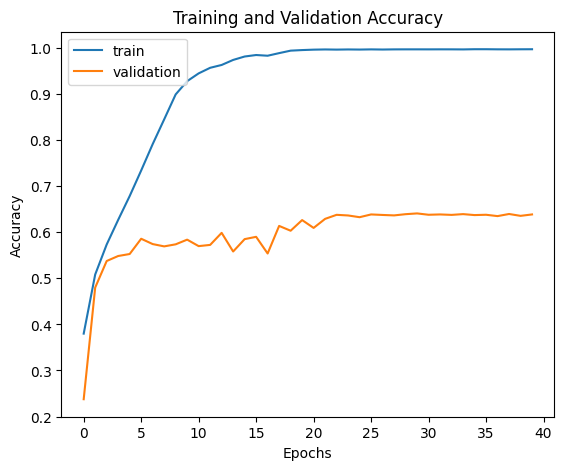

In [11]:
plt.figure(figsize=(14,5))
plt.subplot(1,2,2)
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Training and Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend(['train', 'validation'], loc='upper left')

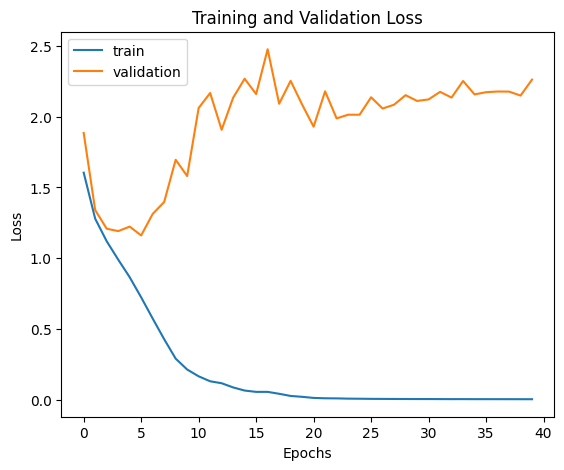

In [12]:
plt.figure(figsize=(14,5))
plt.subplot(1,2,2)
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend(['train', 'validation'], loc='upper left')
plt.show()

In [13]:
y_true = test_data.classes
predictions = model.predict(test_data)
y_pred = np.argmax(predictions, axis=1)

113/113 [==============================] - 8s 66ms/step


In [14]:
cm = confusion_matrix(y_true, y_pred)

In [15]:
import seaborn as sns

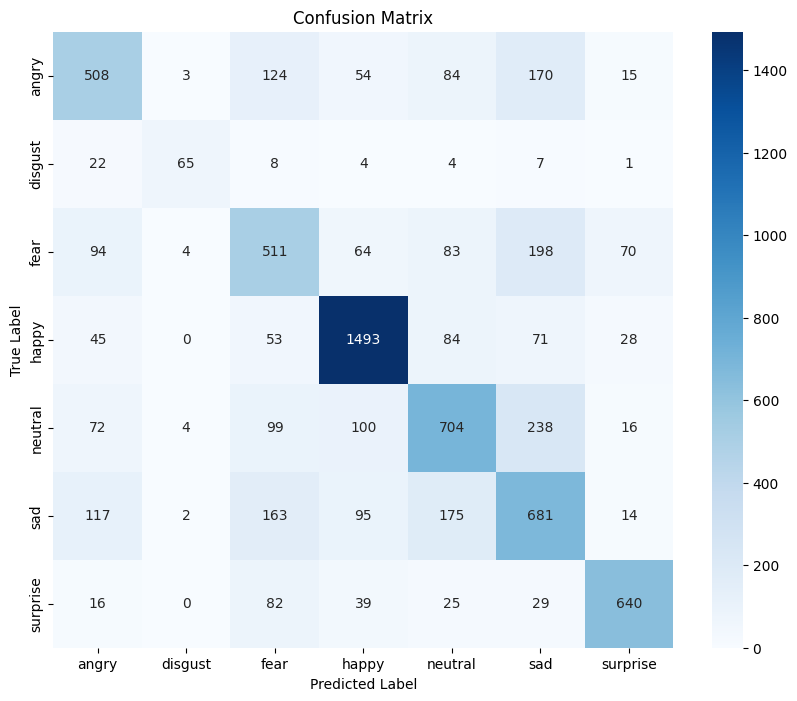

In [16]:
plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=test_data.class_indices.keys(), yticklabels=test_data.class_indices.keys())
plt.title('Confusion Matrix')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.show()